### Feature Improvement

From the part of exploratory data analysis we concluded that:
* Predicting by sex gives an accuracy around 75 and 80 percent
* We do not need neither 'PassengerId', 'Name' or 'Ticket'
* Our most conflictive feature is 'Cabin' becuase its diversity and the missing values. We will try to tune it.
* We did not conclude anything interesting regarding 'Embark' and 'SibSp'
* We have to tackle missing values on 'Age', 'Cabin' and 'Embarked'.
* There are a few amount of continuous variables.

On this section we are going to include another key library for data science: [sckit-learn](https://scikit-learn.org/stable/) which provides a lot of tools for feature transformation, feature selection, classification, regression, dimensionality reduction, and more. And numpy (numerical methods on python) which is quite used by pandas and sklearn

In [1]:
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
file = "train.csv"
data = pd.read_csv(file)

In [3]:
data.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Cabin        object
Embarked     object
dtype: object

#### Cabin

As we said on the explorator part. We saw that cabin is a code which contains a letter and a number. The letter represents the zone. That is why I think it may be interesting to work with this variable.

In [4]:
data.Cabin.dropna().iloc[0]

'C85'

In [5]:
def getSection(cabin):
    
    if isinstance(cabin, str):
        return cabin[0]
    return

data.Cabin = data.Cabin.apply(getSection)

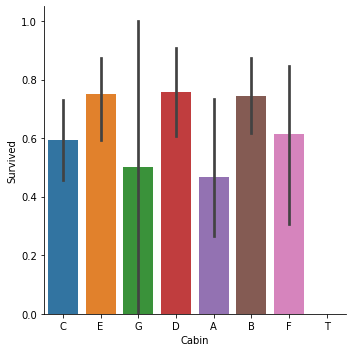

In [6]:
sns.catplot(data = data, x="Cabin", y="Survived", kind="bar")

I can not see any strong relationship among the cabin and the survived column. In addition, we already now that this is the column which has the less data we know. It does not seem worthit to invest on inputing the missing values. Thus we are going to remove this feature. 

In [7]:
data.drop("Cabin", axis=1, inplace=True)

#### Missing values

In the case of age, we can not really use a linear regression to inpute it. We do not have any clear relation among the age an any other continuos variable. Thus we are going to use a knn inputer. Which is able thanks to sklearn.

The knn inputer can not work with categorical data. Thus we are going to use ony the numerical data to feed it.

We also are going to need an additional imputer which can manage categorical data. We are going to use the mode.

Also sklearn need np.nan objects in order to identify missing values.

We will need to separate our data on train and test since the data imputation can vary depending on the data

In [8]:
from sklearn.model_selection import train_test_split

# Split of data
data_train, data_test =  train_test_split(data, test_size=0.2, random_state=42)

In [9]:
data_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
331,0,1,male,45.5,0,0,28.5000,S
733,0,2,male,23.0,0,0,13.0000,S
382,0,3,male,32.0,0,0,7.9250,S
704,0,3,male,26.0,1,0,7.8542,S
813,0,3,female,6.0,4,2,31.2750,S
...,...,...,...,...,...,...,...,...
106,1,3,female,21.0,0,0,7.6500,S
270,0,1,male,NaN,0,0,31.0000,S
860,0,3,male,41.0,2,0,14.1083,S
435,1,1,female,14.0,1,2,120.0000,S


In [10]:
# Convert missing values to np.nan
data_train.applymap(lambda x: x if x else np.nan)

# Creating a list with the numerical features
num = [data_train.dtypes.index[i] for i, dtype in enumerate(data_train.dtypes) if dtype != object]

# Removing Survived from numerical features since we wont have it on the test set.
num.remove("Survived")

# Creating a list with all the categorical features
cat = [data_train.dtypes.index[i] for i, dtype in enumerate(data_train.dtypes) if dtype == object]

In [11]:
from sklearn.impute import KNNImputer, SimpleImputer

imputer = KNNImputer(n_neighbors=5)
imputer_cat = SimpleImputer(strategy="most_frequent")

In [12]:
#Inputing the data
data_train[num] = imputer.fit_transform(data_train[num])
data_train[cat] = imputer_cat.fit_transform(data_train[cat])

data_test[num] = imputer.transform(data_test[num])
data_test[cat] = imputer_cat.transform(data_test[cat])

#### Comments

Pandas also provides ways of tackling  missing data. However, using slkern's tools allows us to use the whole sklearns ecosystem (pipelines, gridsearchers).

### Feature transformation

Transforming the features we have will give us two advantages:
* We can increase the performance of our classifiers (for example a logistic transformation may make a linear regressor work as fu...)

* We can transform categorical data into numerical. That way we can increase the set of classifiers we may try.

#### Encoding
We are going to transform  our categorical variables to a set of binary variables which determines if the original varible belongs to one of the categories. This encoding is called One Hot Encoding.

We are going to transform Pclass (because it is categorical even if they are numbers) and Embarked using this encoding.

Sklearn also supports this encoding.

In [89]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop="first", sparse=False)

If we have three categories 1, 2 and 3. The encoder will generate by default 3 columns. But we can change this to only use 2 columns because we just need 2 columns (if it is not 2 or 3, it should be one). We can do it with different ways. The drop="first" will remove the first column.

In [94]:
# Pclass is numerical, we have to convert it to a string
data_train.Pclass = data_train.Pclass.apply(lambda x: str(x))
data_test.Pclass = data_test.Pclass.apply(lambda x: str(x))

# Categories you need
categories = ["Pclass", "Embarked"]

In [95]:
# Encoding
train_encoded = encoder.fit_transform(data_train[categories])
test_encoded = encoder.transform(data_test[categories])

In [96]:
# New dataframe with codified categorical variables
cols = encoder.get_feature_names_out(categories)
train_encoded_df =  pd.DataFrame(train_encoded, columns=cols)
test_encoded_df = pd.DataFrame(test_encoded, columns=cols)

In [120]:
# Updating the dataframe

#The indexes must concide in order to join
train_encoded_df.index = data_train.index
data_train = data_train.join(train_encoded_df)

test_encoded_df.index = data_test.index
data_test = data_test.join(test_encoded_df)

In [123]:
data_train.drop(categories, axis=1, inplace=True)
data_test.drop(categories, axis=1, inplace=True)

### Conclusions

We have removed Cabin. And we have transformed the data to numerical so we can try a lot of classifiers.
Now we are going to save this transformed data to use in on the next section.

In [132]:
data_train.to_csv("transformed_train.csv")
data_test.to_csv("transformed_test.csv")

[Part 3]()